# 05 Budget Optimizer
Use the modeled response curves and reach simulator to compute the optimal 
spend allocation across channels under budget and practical constraints.

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.optimize import minimize

# Channels we intend to include; we will filter to only those with curves present
CHANNELS = ["LinearTV","Streaming","YouTube","Display","Social"]

CURVE_DIR = Path("../data/processed/response_curves")
OVERLAP_CSV = Path("../data/raw/overlap_matrix.csv")

# CPMs (can tune)
CPM = {"LinearTV":25,"Streaming":18,"YouTube":12,"Display":8,"Social":6}

# Audience size assumption for reporting only (not required for optimization)
AUDIENCE_SIZE = 1_000_000

In [6]:
def reach_from_impressions(impressions, A=1.0, k=1e-7):
    # impressions -> fractional reach of target audience
    return A * (1.0 - np.exp(-k * impressions))

def deduped_reach(spend_dict, cpm_dict, overlap_df, A=0.8, k=1e-7):
    """
    spend_dict: {"Streaming": 250000, ...}
    cpm_dict:   {"Streaming": 18, ...}
    overlap_df: columns: ch_i, ch_j, overlap_rate
    returns: fractional reach in [0, A]
    """
    # per-channel fractional reach
    reach_each = {}
    for ch, spend in spend_dict.items():
        impr = (spend / cpm_dict[ch]) * 1000.0
        reach_each[ch] = reach_from_impressions(impr, A=A, k=k)

    total = sum(reach_each.values())

    # subtract pairwise overlaps (heuristic)
    for _, row in overlap_df.iterrows():
        ci, cj, ov = row["ch_i"], row["ch_j"], float(row["overlap_rate"])
        if ci in reach_each and cj in reach_each:
            total -= ov * min(reach_each[ci], reach_each[cj])

    # clamp
    return float(np.clip(total, 0.0, A))

In [7]:
overlap_df = pd.read_csv(OVERLAP_CSV)
overlap_df.head()

,ch_i,ch_j,overlap_rate
0,LinearTV,Streaming,0.100
1,LinearTV,YouTube,0.228
2,LinearTV,Display,0.194
3,LinearTV,Social,0.065
4,Streaming,YouTube,0.214


In [8]:
def load_response_curve(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    # Drop accidental index columns
    df = df.drop(columns=[c for c in df.columns if str(c).lower().startswith("unnamed")], errors="ignore")

    # Standardize column names (lower/underscored for detection)
    lower_map = {c.lower().strip().replace(" ", "_"): c for c in df.columns}

    # Detect spend
    spend_col = None
    for cand in ("spend","amount","budget"):
        if cand in lower_map:
            spend_col = lower_map[cand]
            break
    if spend_col is None:
        raise ValueError(f"{file_path.name}: cannot find spend column in {list(df.columns)}")

    # Detect best prediction column
    # Prefer boosted (any pred_conversions_* that is not _lr), else fallback to pred_conversions_lr
    pred_cols = [c for c in df.columns if str(c).lower().startswith("pred_conversions")]
    # pick boosted-like first
    boosted = [c for c in pred_cols if not str(c).lower().endswith("_lr")]
    if len(boosted) >= 1:
        pred_col = boosted[0]
    elif "pred_conversions_lr" in df.columns:
        pred_col = "pred_conversions_lr"
    else:
        # fallback: if exactly one numeric col besides spend, use it
        numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != spend_col]
        if len(numeric_cols) == 1:
            pred_col = numeric_cols[0]
        else:
            raise ValueError(f"{file_path.name}: cannot determine prediction column; candidates={pred_cols}")

    out = df[[spend_col, pred_col]].copy()
    out.columns = ["spend","pred_conversions"]

    # Clean
    out["spend"] = pd.to_numeric(out["spend"], errors="coerce")
    out["pred_conversions"] = pd.to_numeric(out["pred_conversions"], errors="coerce")
    out = out.dropna(subset=["spend","pred_conversions"]).sort_values("spend")
    out = out.drop_duplicates(subset=["spend"])
    if len(out) < 2:
        raise ValueError(f"{file_path.name}: need >=2 rows for interpolation")
    return out

# Map channels to expected filenames (snake-case)
fname_map = {
    "LinearTV": "lineartv_response_curve.csv",
    "Streaming": "streaming_response_curve.csv",
    "YouTube": "youtube_response_curve.csv",
    "Display": "display_response_curve.csv",
    "Social": "social_response_curve.csv",
}

resp_curves = {}
missing = []

for ch in CHANNELS:
    f = CURVE_DIR / fname_map[ch]
    if f.exists():
        try:
            resp_curves[ch] = load_response_curve(f)
        except Exception as e:
            print(f"⚠️ {f.name} load problem: {e}")
    else:
        missing.append((ch, f.name))

if missing:
    print("⚠️ Missing curve files:")
    for ch, fn in missing:
        print(f"  {ch}: {fn}")

loaded_channels = list(resp_curves.keys())
print("Loaded channels:", loaded_channels)

Loaded channels: ['LinearTV', 'Streaming', 'YouTube', 'Display', 'Social']


In [9]:
conv_funcs = {}
for ch, dfc in resp_curves.items():
    # interp1d expects increasing x
    conv_funcs[ch] = interp1d(
        dfc["spend"].values,
        dfc["pred_conversions"].values,
        kind="linear",
        fill_value="extrapolate",
        assume_sorted=True
    )

In [10]:
def obj_conversions(spend_vec, channels, conv_funcs):
    spend = dict(zip(channels, spend_vec))
    preds = [float(conv_funcs[ch](spend[ch])) for ch in channels]
    return -np.sum(preds)  # negative for maximize

def obj_reach(spend_vec, channels, cpm_dict, overlap_df):
    spend = dict(zip(channels, spend_vec))
    r = deduped_reach(spend, cpm_dict, overlap_df, A=0.8, k=1e-7)
    return -float(r)

In [11]:
# Solve only for channels we loaded
channels = loaded_channels
if not channels:
    raise RuntimeError("No channels loaded; export curves in Part-3 first.")

BUDGET = 1_000_000.0
bounds = [(0.0, BUDGET)] * len(channels)

def budget_con(x):  # >= 0
    return BUDGET - float(np.sum(x))

cons = ({'type':'ineq','fun': budget_con},)

x0 = np.full(len(channels), BUDGET/len(channels))

# --- Conversions objective ---
res_conv = minimize(
    obj_conversions, x0,
    args=(channels, conv_funcs),
    method="SLSQP", bounds=bounds, constraints=cons,
    options={'maxiter': 500, 'disp': False}
)
opt_spend_conv = dict(zip(channels, res_conv.x))
opt_conv_value = -res_conv.fun

print("Optimal spend (Conversions):")
for ch, v in opt_spend_conv.items():
    print(f"{ch:<10}  ${v:,.0f}")
print(f"Total predicted conversions: {opt_conv_value:,.2f}")

Optimal spend (Conversions):
LinearTV    $200,000
Streaming   $200,000
YouTube     $200,000
Display     $200,000
Social      $200,000
Total predicted conversions: 119.22


In [12]:
# Subset CPM dict to loaded channels
cpm_sub = {ch: CPM[ch] for ch in channels}

res_reach = minimize(
    obj_reach, x0,
    args=(channels, cpm_sub, overlap_df),
    method="SLSQP", bounds=bounds, constraints=cons,
    options={'maxiter': 500, 'disp': False}
)
opt_spend_reach = dict(zip(channels, res_reach.x))
opt_reach_value = -res_reach.fun

print("\nOptimal spend (Deduped Reach):")
for ch, v in opt_spend_reach.items():
    print(f"{ch:<10}  ${v:,.0f}")
print(f"Total deduped reach fraction: {opt_reach_value:.3f} (~{opt_reach_value*AUDIENCE_SIZE:,.0f} people)")


Optimal spend (Deduped Reach):
LinearTV    $200,000
Streaming   $200,000
YouTube     $200,000
Display     $200,000
Social      $200,000
Total deduped reach fraction: 0.800 (~800,000 people)


In [13]:
pd.DataFrame(list(opt_spend_conv.items()), columns=["channel","optimal_spend_conversions"])\
  .to_csv("../data/processed/optimal_spend_conversions.csv", index=False)

pd.DataFrame(list(opt_spend_reach.items()), columns=["channel","optimal_spend_reach"])\
  .to_csv("../data/processed/optimal_spend_reach.csv", index=False)

print("Saved: optimal_spend_conversions.csv, optimal_spend_reach.csv")

Saved: optimal_spend_conversions.csv, optimal_spend_reach.csv


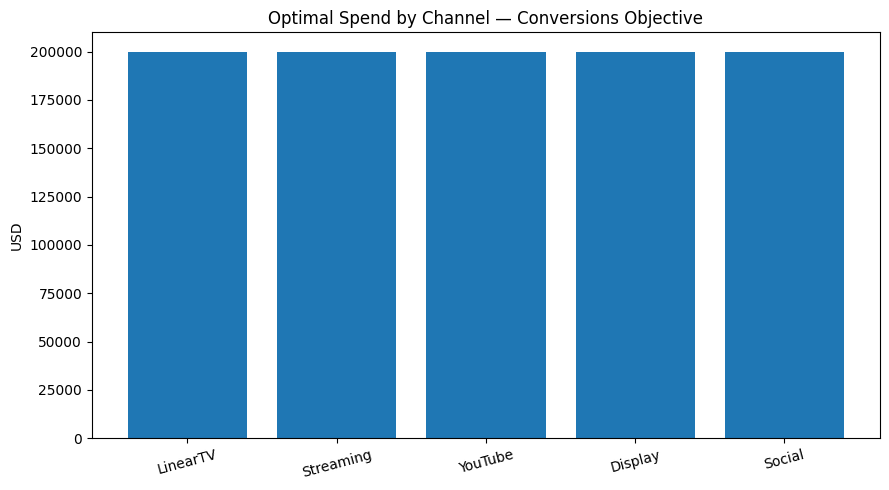

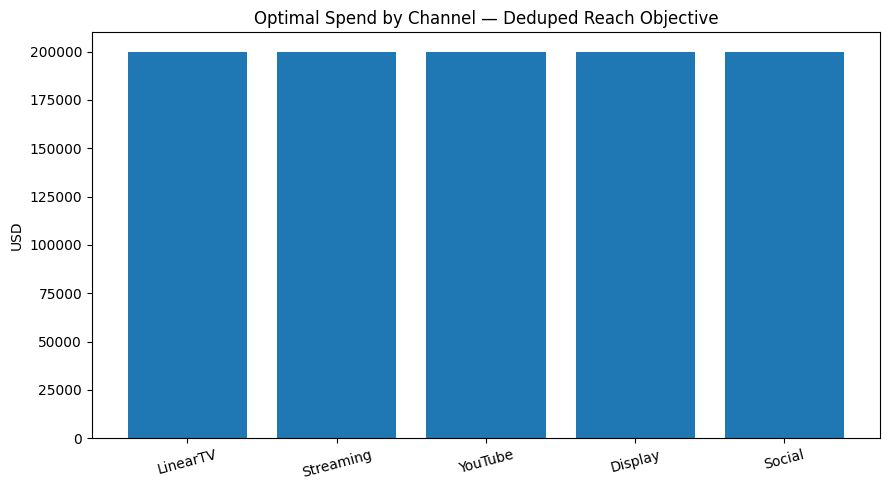

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.bar(list(opt_spend_conv.keys()), list(opt_spend_conv.values()))
plt.title("Optimal Spend by Channel — Conversions Objective")
plt.ylabel("USD")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,5))
plt.bar(list(opt_spend_reach.keys()), list(opt_spend_reach.values()))
plt.title("Optimal Spend by Channel — Deduped Reach Objective")
plt.ylabel("USD")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()